# Kurulum ve Datasetin Oluşturulması

In [285]:
import torch
import random
import wandb
import os

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from kaggle_secrets import UserSecretsClient
from datetime import datetime, timedelta
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [286]:
user_secrets = UserSecretsClient()
wandb_api_key = user_secrets.get_secret("WANDB_API_KEY")
os.environ["WANDB_API_KEY"] = wandb_api_key
wandb.login(relogin=False)

True

In [287]:
ticker = "NFLX"
file_path = f"/kaggle/input/stock-market-data/stock_market_data/nasdaq/csv/{ticker}.csv"

df = pd.read_csv(file_path, usecols=["Date", "Close"])
scaler = MinMaxScaler()
df["Close"] = scaler.fit_transform(df[["Close"]])

print(df)

df["Date"] = pd.to_datetime(df["Date"], format="%d-%m-%Y", errors="coerce")
df.dropna(subset=["Date"], inplace=True)
df.set_index("Date", inplace=True)

            Date     Close
0     23-05-2002  0.001191
1     24-05-2002  0.001211
2     28-05-2002  0.001134
3     29-05-2002  0.001057
4     30-05-2002  0.001010
...          ...       ...
5171  06-12-2022  0.441458
5172  07-12-2022  0.445595
5173  08-12-2022  0.448256
5174  09-12-2022  0.462360
5175  12-12-2022  0.450889

[5176 rows x 2 columns]


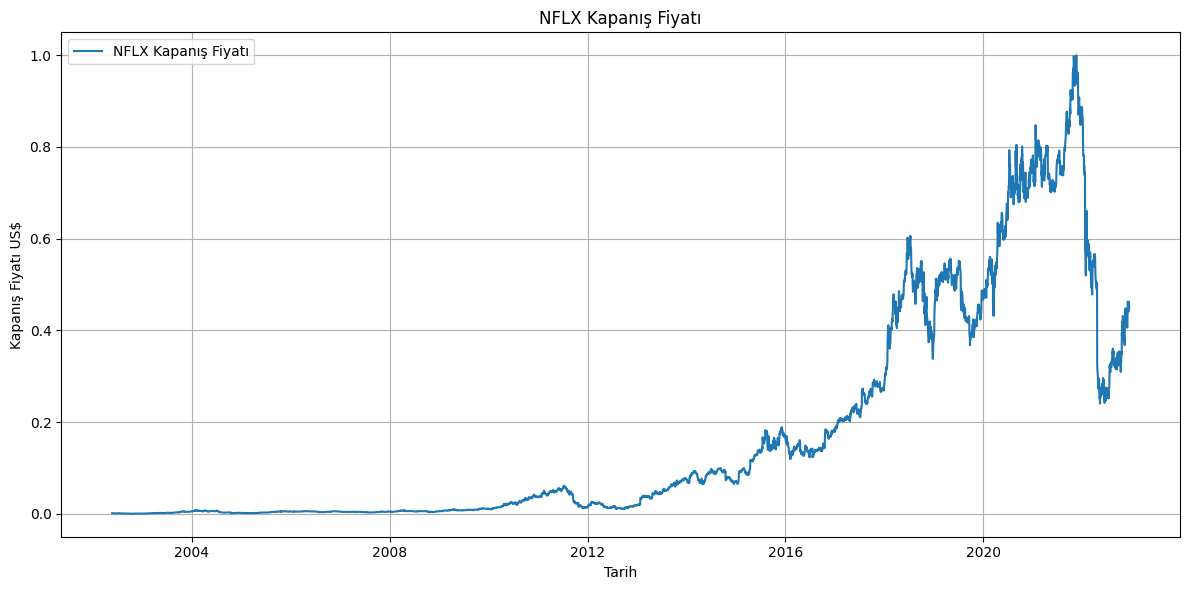

In [288]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Close"], label=f"{ticker} Kapanış Fiyatı")

plt.title(f"{ticker} Kapanış Fiyatı")
plt.xlabel("Tarih")
plt.ylabel("Kapanış Fiyatı US$")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [289]:
def df_to_windowed_df(df, start_date, end_date, window_size=3):
    start_date = pd.to_datetime(start_date, format="%d-%m-%Y")
    end_date = pd.to_datetime(end_date, format="%d-%m-%Y")

    dates = []
    X, Y = [], []

    date_range = df.loc[start_date:end_date].index

    for i in range(window_size, len(date_range)):
        window_dates = date_range[i - window_size:i + 1]
        window_values = df.loc[window_dates, "Close"].values

        if len(window_values) != window_size + 1:
            continue

        x, y = window_values[:-1], window_values[-1]

        dates.append(window_dates[-1])
        X.append(x)
        Y.append(y)

    windowed_df = pd.DataFrame(X, columns=[f"Target-{i}" for i in range(window_size, 0, -1)])
    windowed_df["Target"] = Y
    windowed_df["Target Date"] = dates

    return windowed_df[["Target Date"] + [f"Target-{i}" for i in range(window_size, 0, -1)] + ["Target"]]

windowed_df = df_to_windowed_df(df, "25-03-2005", "23-03-2022", window_size=21)
windowed_df

,Target Date,Target-21,Target-20,Target-19,Target-18,Target-17,Target-16,Target-15,Target-14,Target-13,...,Target-9,Target-8,Target-7,Target-6,Target-5,Target-4,Target-3,Target-2,Target-1,Target
0,2005-04-26,0.001482,0.001548,0.001579,0.001703,0.001699,0.001725,0.001697,0.001754,0.001783,...,0.001963,0.001936,0.001876,0.001802,0.001862,0.001827,0.001971,0.001775,0.001837,0.001796
1,2005-04-27,0.001548,0.001579,0.001703,0.001699,0.001725,0.001697,0.001754,0.001783,0.001942,...,0.001936,0.001876,0.001802,0.001862,0.001827,0.001971,0.001775,0.001837,0.001796,0.001837
2,2005-04-28,0.001579,0.001703,0.001699,0.001725,0.001697,0.001754,0.001783,0.001942,0.001918,...,0.001876,0.001802,0.001862,0.001827,0.001971,0.001775,0.001837,0.001796,0.001837,0.001839
3,2005-04-29,0.001703,0.001699,0.001725,0.001697,0.001754,0.001783,0.001942,0.001918,0.001872,...,0.001802,0.001862,0.001827,0.001971,0.001775,0.001837,0.001796,0.001837,0.001839,0.001847
4,2005-05-02,0.001699,0.001725,0.001697,0.001754,0.001783,0.001942,0.001918,0.001872,0.001963,...,0.001862,0.001827,0.001971,0.001775,0.001837,0.001796,0.001837,0.001839,0.001847,0.001852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4253,2022-03-17,0.588857,0.575289,0.558784,0.565467,0.545346,0.530997,0.563645,0.564758,0.570139,...,0.522708,0.506117,0.493821,0.518455,0.515533,0.491738,0.478271,0.496700,0.516633,0.536696
4254,2022-03-18,0.575289,0.558784,0.565467,0.545346,0.530997,0.563645,0.564758,0.570139,0.558162,...,0.506117,0.493821,0.518455,0.515533,0.491738,0.478271,0.496700,0.516633,0.536696,0.550004
4255,2022-03-21,0.558784,0.565467,0.545346,0.530997,0.563645,0.564758,0.570139,0.558162,0.549179,...,0.493821,0.518455,0.515533,0.491738,0.478271,0.496700,0.516633,0.536696,0.550004,0.541310
4256,2022-03-22,0.565467,0.545346,0.530997,0.563645,0.564758,0.570139,0.558162,0.549179,0.531879,...,0.518455,0.515533,0.491738,0.478271,0.496700,0.516633,0.536696,0.550004,0.541310,0.553360


In [290]:
def windowed_df_to_date_X_y(windowed_df):
    feature_cols = [col for col in windowed_df.columns if col.startswith("Target-")]
    target_col = "Target"
    date_col = "Target Date"

    dates = windowed_df[date_col].to_numpy()
    X = windowed_df[feature_cols].to_numpy().astype(np.float32).reshape(len(dates), len(feature_cols), 1)
    y = windowed_df[target_col].to_numpy().astype(np.float32)

    return dates, X, y

dates, X, y = windowed_df_to_date_X_y(windowed_df)
dates.shape, X.shape, y.shape

((4258,), (4258, 21, 1), (4258,))

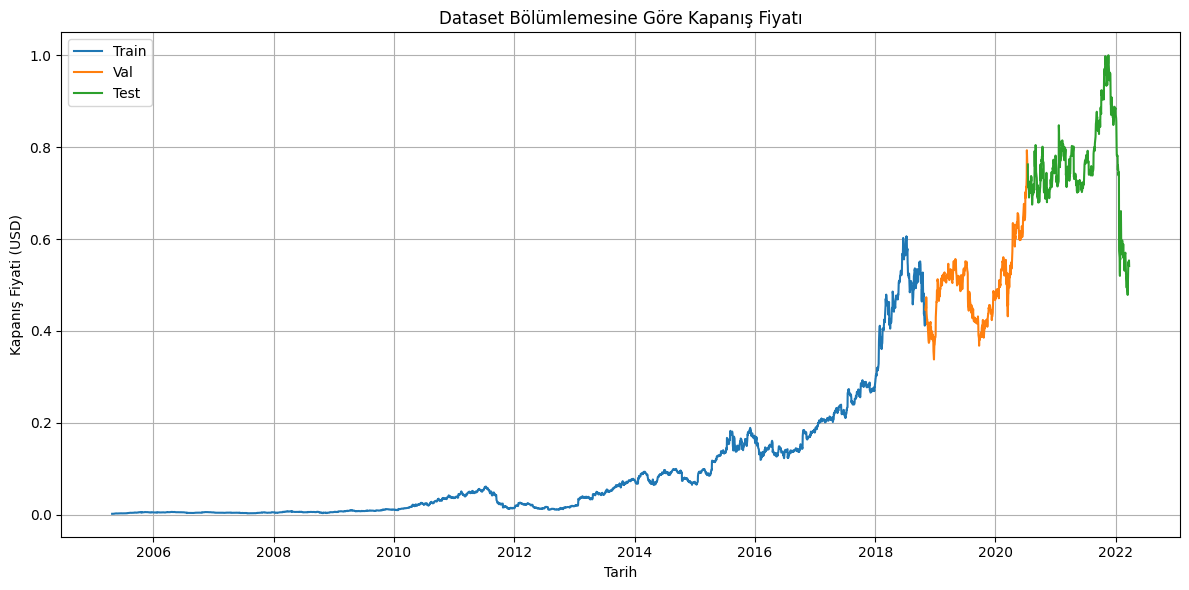

In [291]:
    q_80 = int(len(dates) * .8)
    q_90 = int(len(dates) * .9)
    
    dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
    dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
    dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]
    
    plt.figure(figsize=(12, 6))
    
    plt.plot(dates_train, y_train, label="Train")
    plt.plot(dates_val, y_val, label="Val")
    plt.plot(dates_test, y_test, label="Test")
    
    plt.title("Dataset Bölümlemesine Göre Kapanış Fiyatı")
    plt.xlabel("Tarih")
    plt.ylabel("Kapanış Fiyati (USD)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Modelin Oluşturulması ve Eğitimi

In [292]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("Kullanılan cihaz:", device)

Kullanılan cihaz: cpu


In [293]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, fc_dim=32):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.bidirectional = True

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            batch_first=True,
            bidirectional=self.bidirectional
        )

        lstm_output_dim = hidden_dim * 2 if self.bidirectional else hidden_dim

        self.fc = nn.Sequential(
            nn.Linear(lstm_output_dim, fc_dim),
            nn.ReLU(),
            nn.Linear(fc_dim, 1)
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # (batch, seq_len, hidden_dim * 2)
        last_hidden = lstm_out[:, -1, :]
        return self.fc(last_hidden)

model = LSTMModel().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", patience=5, factor=0.5
)

In [294]:
def to_tensor_dataset(X, y):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    return TensorDataset(X_tensor, y_tensor)

train_loader = DataLoader(to_tensor_dataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(to_tensor_dataset(X_val, y_val), batch_size=32)

In [295]:
wandb.init(
    project="Hisse Fiyatı Tahminleyicisi",
    config={
        "model": "LSTM",
        "window_size": 21,
        "hidden_dim": 64,
        "fc_dim": 32,
        "batch_size": 32,
        "lr": 1e-3,
        "epochs": 250,
        "patience": 15,
    }
)

best_val_loss = float("inf")
best_model_state = None
patience = 15
epochs_without_improve = 0

for epoch in range(1, 251):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    val_mae = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = model(X_batch)
            batch_loss = criterion(predictions, y_batch)
            val_loss += batch_loss.item() * X_batch.size(0)
            val_mae += torch.sum(torch.abs(predictions - y_batch)).item()

    val_loss /= len(val_loader.dataset)
    val_mae /= len(val_loader.dataset)
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        torch.save(best_model_state, "best_model.pth")
        epochs_without_improve = 0
    else:
        epochs_without_improve += 1
        if epochs_without_improve == patience:
            print("early stop")
            break

    wandb.log({
        "epoch": epoch,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "val_mae": val_mae,
        "lr": optimizer.param_groups[0]["lr"]
    })

    if epoch % 10 == 0:
        print(f"Epoch {epoch:3d}: Train Loss = {train_loss:.6f}, Val Loss = {val_loss:.6f}, Val MAE = {val_mae:.4f}")

Epoch  10: Train Loss = 0.000058, Val Loss = 0.000595, Val MAE = 0.0177
Epoch  20: Train Loss = 0.000031, Val Loss = 0.000264, Val MAE = 0.0119
Epoch  30: Train Loss = 0.000026, Val Loss = 0.000198, Val MAE = 0.0103
Epoch  40: Train Loss = 0.000022, Val Loss = 0.000333, Val MAE = 0.0151
Epoch  50: Train Loss = 0.000019, Val Loss = 0.000183, Val MAE = 0.0100
Epoch  60: Train Loss = 0.000017, Val Loss = 0.000206, Val MAE = 0.0105
Epoch  70: Train Loss = 0.000016, Val Loss = 0.000236, Val MAE = 0.0114
early stop


In [296]:
model.load_state_dict(torch.load("best_model.pth"))
print("Kaydedilen en iyi model yüklendi.")

Kaydedilen en iyi model yüklendi.


# Modelin Değerlendirilmesi

In [297]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

with torch.no_grad():
    train_preds = model(X_train_tensor).squeeze().cpu().numpy()
    val_preds = model(X_val_tensor).squeeze().cpu().numpy()
    test_preds = model(X_test_tensor).squeeze().cpu().numpy()

y_train_real = scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_val_real   = scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()
y_test_real  = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

train_preds_real = scaler.inverse_transform(train_preds.reshape(-1, 1)).flatten()
val_preds_real   = scaler.inverse_transform(val_preds.reshape(-1, 1)).flatten()
test_preds_real  = scaler.inverse_transform(test_preds.reshape(-1, 1)).flatten()

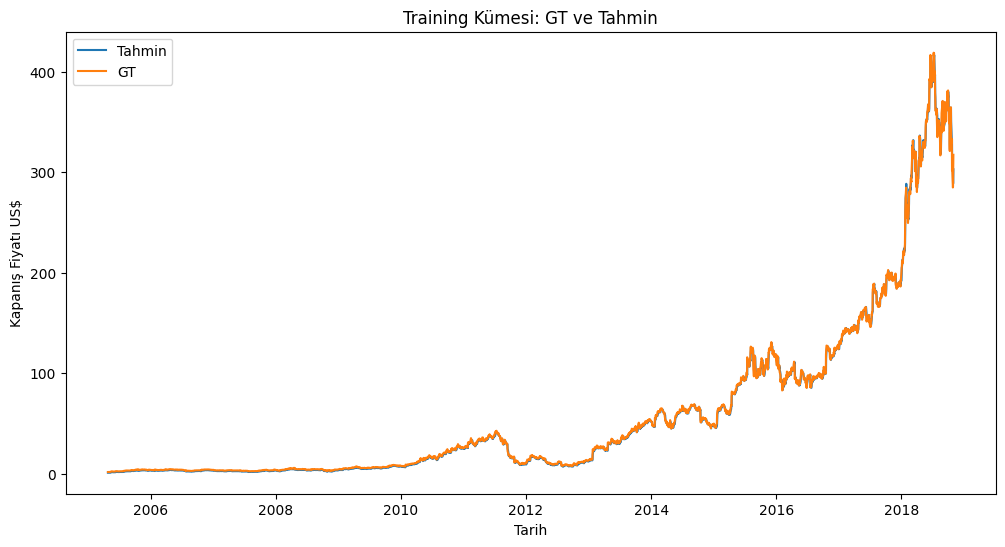

In [298]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)

model.eval()
with torch.no_grad():
    train_preds = model(X_train_tensor).squeeze().cpu().numpy()
    

assert len(train_preds) == len(dates_train) == len(y_train)

plt.figure(figsize=(12, 6))
plt.plot(dates_train, train_preds_real, label="Tahmin")
plt.plot(dates_train, y_train_real, label="GT")
plt.xlabel("Tarih")
plt.ylabel("Kapanış Fiyatı US$")
plt.title("Training Kümesi: GT ve Tahmin")
plt.legend()
plt.show()

In [299]:
def evaluate_predictions(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{name} MAE:  {mae:.4f}")
    return mae

evaluate_predictions(y_train_real, train_preds_real, name="Train")
evaluate_predictions(y_val_real, val_preds_real, name="Val")
test_mae = evaluate_predictions(y_test_real, test_preds_real, name="Test")

wandb.log({
    "test_mae": test_mae,
})

wandb.finish()

Train MAE:  1.4653
Val MAE:  6.8469
Test MAE:  10.6416


epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
lr,█████████████████████████▄▄▄▄▄▂▂▂▂▂▁▁▁▁▁
test_mae,▁
train_loss,█▅█▅▄▃▃▃▂▂▂▃▂▂▂▂▁▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mae,█▃▅▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,75
lr,6e-05
test_mae,10.64165
train_loss,2e-05
val_loss,0.00019


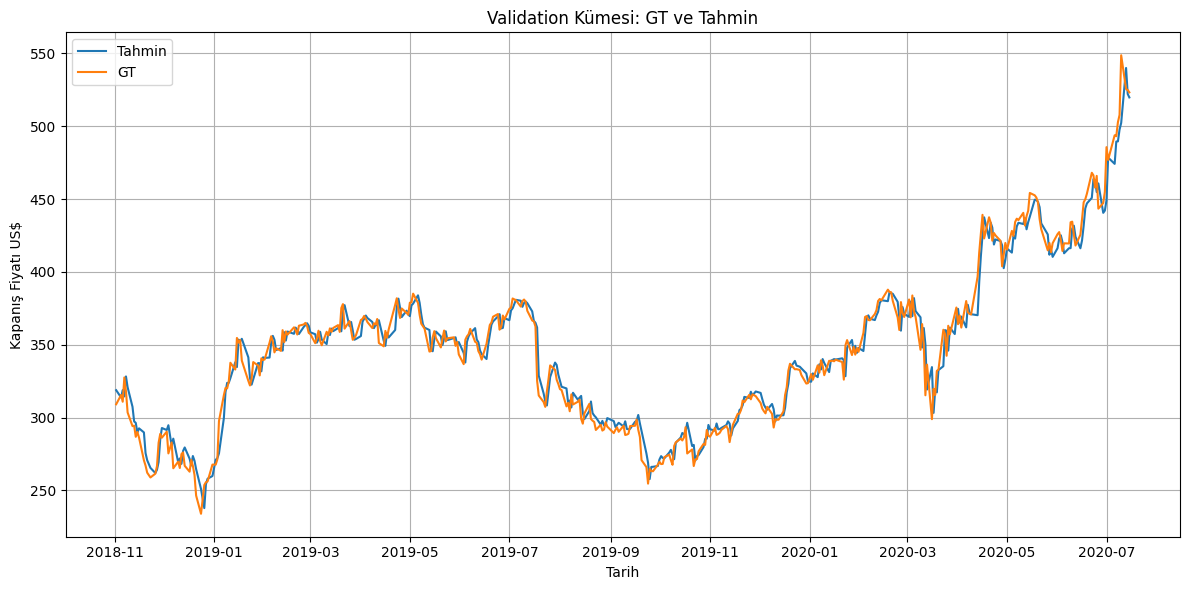

In [300]:
model.eval()

X_val_tensor_device = X_val_tensor.to(device)

with torch.no_grad():
    val_preds = model(X_val_tensor_device).cpu().squeeze().numpy()

plt.figure(figsize=(12, 6))
plt.plot(dates_val, val_preds_real, label="Tahmin")
plt.plot(dates_val, y_val_real, label="GT")
plt.xlabel("Tarih")
plt.ylabel("Kapanış Fiyatı US$")
plt.title("Validation Kümesi: GT ve Tahmin")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

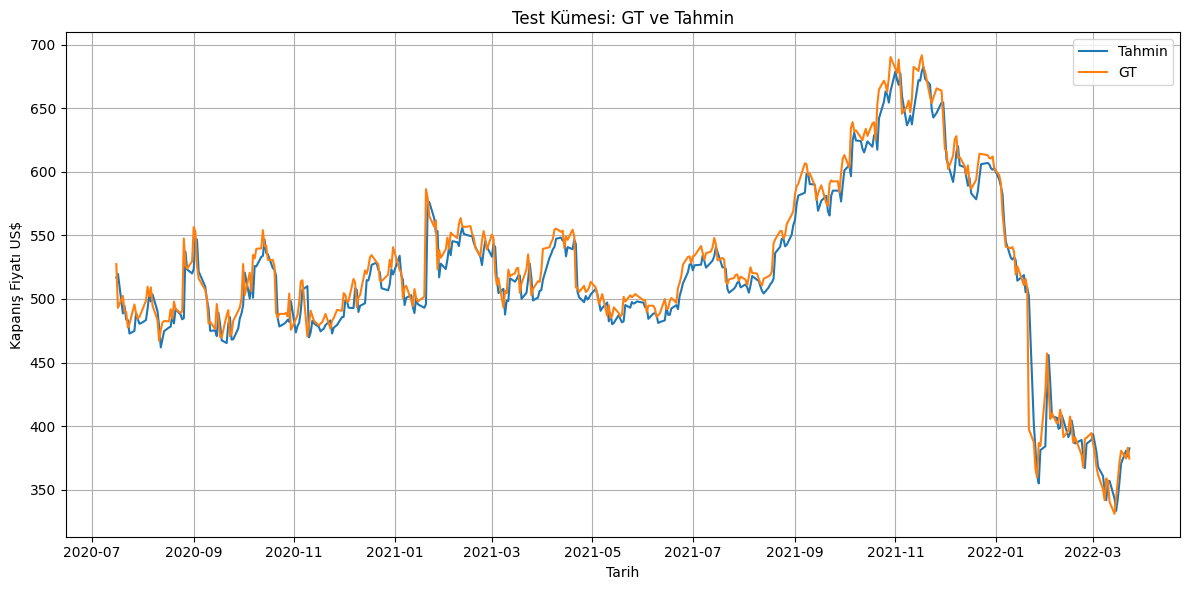

In [301]:
model.eval()

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

with torch.no_grad():
    test_preds = model(X_test_tensor).cpu().squeeze().numpy()

plt.figure(figsize=(12, 6))
plt.plot(dates_test, test_preds_real, label="Tahmin")
plt.plot(dates_test, y_test_real, label="GT")
plt.xlabel("Tarih")
plt.ylabel("Kapanış Fiyatı US$")
plt.title("Test Kümesi: GT ve Tahmin")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

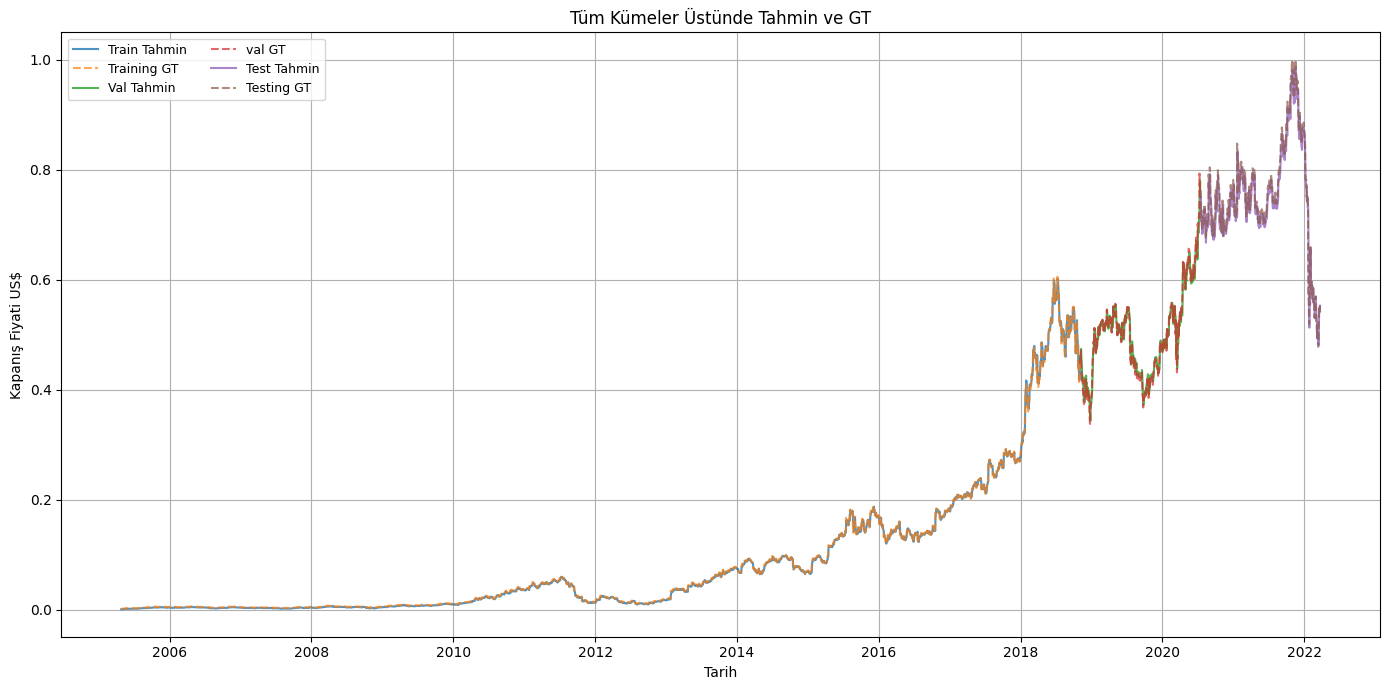

In [302]:
plt.figure(figsize=(14, 7))

plt.plot(dates_train, train_preds, label="Train Tahmin", alpha=0.8)
plt.plot(dates_train, y_train, label="Training GT", linestyle="dashed", alpha=0.7)

plt.plot(dates_val, val_preds, label="Val Tahmin", alpha=0.8)
plt.plot(dates_val, y_val, label="val GT", linestyle="dashed", alpha=0.7)

plt.plot(dates_test, test_preds, label="Test Tahmin", alpha=0.8)
plt.plot(dates_test, y_test, label="Testing GT", linestyle="dashed", alpha=0.7)

plt.xlabel("Tarih")
plt.ylabel("Kapanış Fiyati US$")
plt.title("Tüm Kümeler Üstünde Tahmin ve GT")
plt.legend(ncol=2, fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()